In [ ]:
!pip install livelossplot==0.5.1 --quiet

import gc
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
import cv2 as cv
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
from skimage.transform import resize 
from torch.utils.data import random_split, DataLoader, Dataset, ConcatDataset

from PIL import Image

from matplotlib import pyplot as plt

from livelossplot import PlotLosses

from google.colab import drive
import os
from os import listdir
from sys import getsizeof
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
class h5DatasetSlice(Dataset):

    def __init__(self, file_path, func=None, portion=(0, 1)):
        # file_path: path to .h5 file
        self.file = h5py.File(file_path + "DIML.h5", "r")
        self.func = func

        self.rgb_dbs = sorted([key for key in self.file.keys() \
                                if key[:3] == "rgb"])
        self.depth_dbs = sorted([key for key in self.file.keys() \
                                if key[:5] == "depth"])
        portion = [int(k*len(self.rgb_dbs)) for k in portion]

        self.rgb_dbs = self.rgb_dbs[portion[0] : portion[1]]
        self.depth_dbs = self.depth_dbs[portion[0] : portion[1]]
        
        self.totens = transforms.ToTensor()

    def __getitem__(self, index):
        
        rgb = self.file[self.rgb_dbs[index]][:]
        depth = self.file[self.depth_dbs[index]][:]

        if self.func:
            rgb, depth = self.func(rgb, depth)
        else:
            rgb = self.totens(rgb)
            depth = self.totens(depth.astype(np.float64) / 65535.0)
            
        return rgb, depth

    
    def __len__(self):
        return min(len(self.rgb_dbs), len(self.depth_dbs))

class SkipUpconv2(nn.Module):
    def __init__(self, in_channels, out_channels, activ=nn.LeakyReLU(0.2)):
        super(SkipUpconv2, self).__init__()

        mid_channels = (in_channels + out_channels) // 2
        self.activ = activ
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels = mid_channels,
            kernel_size = 3,
            stride = 1,
            padding = 1,
        )
        self.conv2 = nn.Conv2d(
            in_channels=mid_channels,
            out_channels = out_channels,
            kernel_size = 3,
            stride = 1,
            padding = 1,
        )

    def forward(self, small, big):
        scaled = F.interpolate(small, size=big.shape[2:], mode='bilinear', 
                               align_corners=True)
        x = self.activ(self.conv1(torch.cat((scaled, big), dim=1)))
        x = self.activ(self.conv2(x))

        return F.interpolate(x, scale_factor=2, mode='bilinear', 
                             align_corners=True)
        
def vecinfo(vec):
    totens = transforms.ToTensor()
    try:
        vec = totens(vec)
    except:
        pass
    print("shape: {}, min: {}, max: {}, mean: {}".format(
        vec.shape,
        torch.min(vec),
        torch.max(vec),
        torch.mean(vec)
    ))

def alter(rgb, depth):

    totens = transforms.ToTensor()

    rgb, depth = random_rotate((rgb, depth), max_angle=15, fill=1)
    rgb, depth = random_hflip((rgb, depth))
    rgb = TF.center_crop(rgb, (400, 533))
    depth = TF.center_crop(depth, (400, 533))
    rgb = resize(np.array(rgb), (225, 300))
    depth = resize(np.array(depth), (225, 300))
    rgb, depth = random_crop((np.array(rgb, dtype='float64'), np.array(depth, dtype='float64')), (224, 224))

    rgb = totens(rgb)
    depth = totens(depth)

    depth = transforms.Normalize(0,0.1217)(depth)

    return rgb, depth

def random_crop(data, size):
    rgb, depth = data
    h, w = rgb.shape[:2]
    new_h, new_w = size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    rgb = rgb[top: top + new_h,
              left: left + new_w]
    depth = depth[top: top + new_h,
                  left: left + new_w]
    
    return rgb, depth

def random_rotate(data, max_angle, resample=False, expand=False, 
                  center=None, fill=None):
    rgb, depth = data
    rgb = Image.fromarray(rgb)
    depth = Image.fromarray(depth)
    angle = np.random.uniform(-max_angle, max_angle)
    return (TF.rotate(rgb, angle, resample, expand, center, fill),
            TF.rotate(depth, angle, resample, expand, center, fill))

def random_hflip(data, p=0.5):
    rgb, depth = data

    if torch.rand(1) < p:
        return TF.hflip(rgb), TF.hflip(depth)
    
    return rgb, depth

def alter_val(rgb, depth):

    totens = transforms.ToTensor()

    rgb = TF.center_crop(Image.fromarray(rgb), (400, 533))
    depth = TF.center_crop(Image.fromarray(depth), (400, 533))
    rgb = resize(np.array(rgb), (224, 224))
    depth = resize(np.array(depth), (224, 224))

    rgb = totens(rgb)
    depth = totens(depth)

    depth = transforms.Normalize(0,0.1217)(depth)

    return rgb, depth

def load_dataset(file_path, batch_size, ratios=(.7, .15, .15), shuffle=True):
    train_data = h5DatasetSlice(file_path=file_path, func=alter, 
                                portion=(0, ratios[0]))
    val_data = h5DatasetSlice(file_path=file_path, func=alter_val,
                                portion=(ratios[0], ratios[0]+ratios[1]))
    test_data = h5DatasetSlice(file_path=file_path, func=alter_val,
                                portion=(ratios[0]+ratios[1], 1))
    
    print(len(train_data), len(val_data), len(test_data))
    
    train_loader = DataLoader(train_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)

    return train_loader, val_loader, test_loader

def valid_loss(model, criterion, val_loader, index):

    model.eval()

    with torch.no_grad():

        for i, (rgb, depth) in enumerate(val_loader, \
                                         index % (len(val_loader) - 1)):

            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()
            
            pred = model(rgb.float())
            del rgb

            return torch.sqrt(criterion(depth.squeeze(), pred.squeeze())).item()

def trainGAN(generator, discriminator, batch_size=16, gen_lr=0.01, dis_lr=0.01,
             stepped_epochs=50, num_epochs=1, ratios=(.7, .15, .15), pretrained=True):
    

    plotlosses = PlotLosses(groups={'Losses': ['gen', 'dis']})

    print("loading data...")

    if pretrained:
        checkpoint_name = 'skipautoenc3.pth'
        checkpoint = torch.load(
            "/content/gdrive/My Drive/APS360_Project/Checkpoints/"
            + checkpoint_name)
        generator.load_state_dict(checkpoint['model_state_dict'])

    train_loader, val_loader = load_dataset(
        file_path=darie_path,
        batch_size=batch_size,
        ratios=ratios
        )[:2]

    print("data loading complete")

    torch.manual_seed(69)

    criterion = nn.BCELoss()

    gen_optim = optim.Adam(generator.parameters(), lr=gen_lr, betas=(0.5, 0.999))
    dis_optim = optim.Adam(discriminator.parameters(), lr=dis_lr, betas=(0.5, 0.999))

    
    gen_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=gen_optim,
                                        factor=0.5, patience=50, verbose=True)
    dis_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=dis_optim,
                                        factor=0.5, patience=20, verbose=True)
    

    # set models in training mode
    generator.train()
    discriminator.train()

    # float tensors for correct/incorrect discriminator labels
    true_labels = torch.FloatTensor(np.ones(shape=(batch_size,1)))
    false_labels = torch.FloatTensor(np.zeros(shape=(batch_size,1)))

    if torch.cuda.is_available():
        true_labels = true_labels.cuda()
        false_labels = false_labels.cuda()
    
    # initialize loss values for selective training
    gen_loss_item = 1.0
    dis_loss_item = 1.0

    # keep track of better gen and dis losses
    best_gen = 1.0
    best_dis = 1.0

    for epoch in range(num_epochs):

        for i, (rgb, depth) in enumerate(train_loader, 0):

            j = epoch * int (len(train_loader.dataset) / batch_size) + i

            # move tensors to GPU
            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()

            '''
            TRAIN GENERATOR
            '''

            if (gen_loss_item >= dis_loss_item and j < stepped_epochs) or \
                                                        j > stepped_epochs:
            
                gen_optim.zero_grad()
                
                # generate batch of depth maps
                gen_depth = generator(rgb.float())

                plt.imshow(gen_depth.cpu().detach().numpy()[0].squeeze(), cmap='inferno')
                plt.show()

                # pass images through discriminator and check loss
                validity = discriminator(rgb.float(), gen_depth)
                gen_loss = criterion(validity, true_labels)
                gen_loss_item = gen_loss.item()

                gen_sched.step(gen_loss_item)

                gen_loss.backward()
                gen_optim.step()

            '''
            TRAIN DISCRIMINATOR
            '''

            if (dis_loss_item >= gen_loss_item and j < stepped_epochs) or \
                                                        j > stepped_epochs:

                dis_optim.zero_grad()

                # loss for real images
                validity_real = discriminator(rgb.float(), depth.float())
                real_dis_loss = criterion(validity_real, true_labels)

                # loss for generated images
                validity_fake = discriminator(rgb.float(), gen_depth.detach())
                fake_dis_loss = criterion(validity_fake, false_labels)

                # average the two losses
                dis_loss = (real_dis_loss + fake_dis_loss) / 2
                dis_loss_item = dis_loss.item()

                dis_sched.step(dis_loss_item)

                dis_loss.backward()
                dis_optim.step()

            plotlosses.update({
                'gen': gen_loss_item,
                'dis': dis_loss_item
            })
            plotlosses.send()

            if torch.cuda.is_available():
                torch.cuda.synchronize()
        

darie_path = "/content/gdrive/My Drive/APS360_Project/Data/"

In [ ]:
class Generator(nn.Module):
    def __init__(self, channels=(640, 300, 150, 50)):
        super(Generator, self).__init__()

        self.mobilenet = models.mobilenet_v2(pretrained=True).cuda()

        self.norm1 = nn.BatchNorm2d(channels[1])
        self.norm2 = nn.BatchNorm2d(channels[3])

        self.dec1 = nn.Conv2d(1280, channels[0], kernel_size=3, stride=1, 
                              padding=1)
        self.dec2 = SkipUpconv2(channels[0]+96, channels[1])
        self.dec3 = SkipUpconv2(channels[1]+32, channels[2])
        self.dec4 = SkipUpconv2(channels[2]+24, channels[3])
        self.dec5 = SkipUpconv2(channels[3]+16, 1)

        self.sig = nn.Sigmoid()
    
    def forward(self, x0):
        features = [x0]
        for name, module in self.mobilenet.features._modules.items():
            features.append(module(features[-1]))
        
        x1 = self.dec1(features[19])
        x2 = self.norm1(self.dec2(x1, features[14]))
        x3 = self.dec3(x2, features[7])
        x4 = self.norm2(self.dec4(x3, features[4]))
        x5 = self.dec5(x4, features[2])

        return self.sig(x5)

class Discriminator(nn.Module):
    def __init__(self, activ=nn.LeakyReLU(0.1)):
        super(Discriminator, self).__init__()

        self.conv = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(4, 20, kernel_size=3, padding=1, stride=2),
            activ,
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(20),
            nn.Conv2d(20, 50, kernel_size=3, padding=1, stride=2),
            activ
        )

        self.lin = nn.Sequential(
            nn.Linear(14*14*50, 40),
            activ,
            nn.Linear(40, 1),
            nn.Sigmoid()
        )

    def forward(self, rgb, depth):
        
        depth = F.interpolate(depth, (224, 224))
        #depth1 = np.moveaxis(np.array(depth[0].detach().cpu()), 0, -1).squeeze()
        #plt.imshow(depth1, cmap='gray')
        x_ = self.conv(torch.cat((rgb, depth), dim=1))
        return self.lin(x_.view(x_.shape[0], -1))

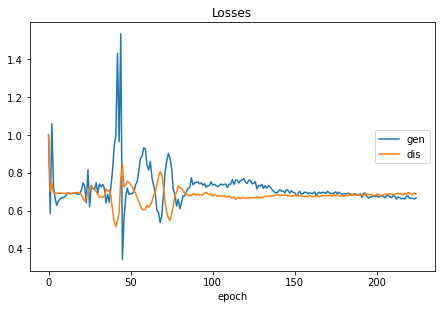

Losses
	gen              	 (min:    0.341, max:    1.536, cur:    0.668)
	dis              	 (min:    0.514, max:    1.000, cur:    0.687)


In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

gen = Generator()
dis = Discriminator()

print(sum(p.numel() for p in gen.parameters()))
print(sum(p.numel() for p in dis.parameters()))

if torch.cuda.is_available():
    print("GPU available")
    gen.cuda()
    dis.cuda()

trainGAN(gen, dis, batch_size=64, gen_lr=4e-5, dis_lr=4e-4, 
          stepped_epochs=0, num_epochs=5, ratios=(.8, .15, .05))
